***
# Machine default recognition

`Dramé Omar`
***

# Problem description

A metal factory desires to improve its quality process with cameras on it’s assembly chain. Build a machine learning model which is able to identify metal output containing defaults. Identify the position of the defaults in the images. The dataset is composed of 1 100 images, 1 000 without defaults and 100 with defaults.

# Imports 

In [2]:
import cv2
import pandas as pd
import zipfile
import shutil
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import io as StringIO
from skimage import io, transform, img_as_float
from tensorflow import keras
from tensorflow.keras.models import Model
import tensorflow as tf
import pathlib
import os
import numpy as np
import random
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from pathlib import Path
import tensorflow.keras.layers as tkl
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import optimizers
# ! pip install opencv-python
# !pip install --q tensorflow
# ! pip install scikit-image
# !pip install pillow

# The dataset

 We can take a look at some of the images.

In [3]:
def showImages(number_images = 10, class_number=1,pixel="off"):
    """
    Show a specified number of images from the raw dataset
    """
    if class_number == 1:
        class_name = 'without'
    else :
        class_name = 'with'

    zip_file = 'EXERCISE_1_train_data_'+class_name+'_default.zip'
    folder_in_zip = 'train_data_'+class_name+'_default/'

    with zipfile.ZipFile(zip_file, 'r') as archive:
        image_files = [f for i,f in enumerate(archive.namelist()) if f.startswith(folder_in_zip) and f.endswith('.jpg') if i <= number_images]
        i = 0
        for image_file in image_files:
            i = i + 1
            file_buffer = StringIO.BytesIO(archive.read(image_file))
            img = img_as_float(io.imread(file_buffer))
            plt.imshow(img)
            plt.axis('off')
            plt.title('Image ' + str(i) +" - "+class_name + ' defaults')
            plt.show()
            """if pixel == "on":
                plt.subplot(141)
                np.set_printoptions(precision=4, suppress=True)
                print('Image ' + str(i+1) + " - " + class_name + ' defaults:\n', np.array2string(img, separator=','))
                plt.show()"""
    pass

In [4]:
def getImage(image_number = 1, class_number=0):
    """
    Get a spesific image from the raw dataset
    """
    if class_number == 0:
        class_name = 'without'
    else :
        class_name = 'with'

    zip_file = 'EXERCISE_1_train_data_'+class_name+'_default.zip'
    folder_in_zip = 'train_data_'+class_name+'_default/'
    image_files = []

    with zipfile.ZipFile(zip_file, 'r') as archive:
        for i,f in enumerate(archive.namelist()):
            if f.startswith(folder_in_zip) and f.endswith('.jpg') :
                image_files.append(f)
                if i == image_number:
                    file_buffer = StringIO.BytesIO(archive.read(image_files[image_number-1]))
                    img = img_as_float(io.imread(file_buffer))
                    plt.imshow(img)
                    plt.axis('off')
                    plt.title('Image ' + str(image_number) +" - " + class_name + ' defaults')
                    plt.show()
                    pass

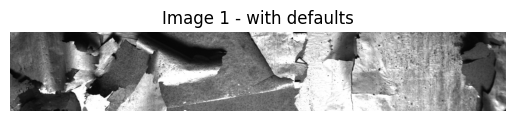

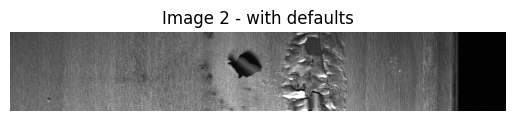

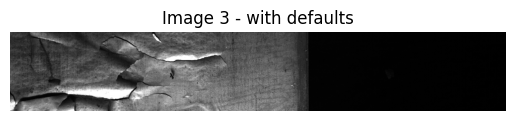

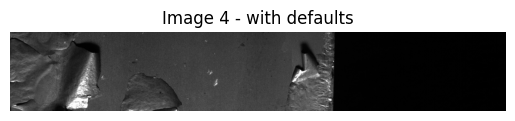

In [5]:
showImages(4,0)

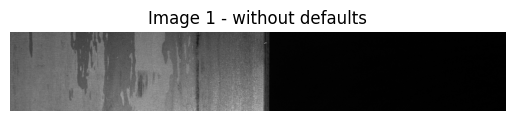

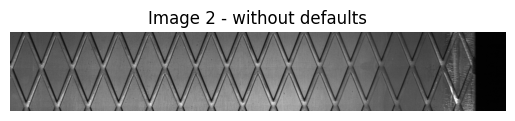

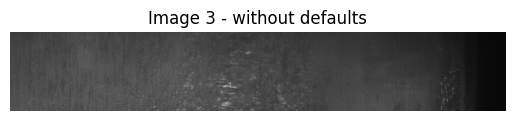

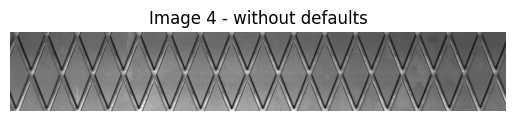

In [6]:
showImages(4,1)

In [7]:
# showImages(100,0)
# showImages(100,1)

By exploring the images we come across two problems.
- The datase is very **unbalanced**
- In the class without default , there are images that are very similar (*examples bellow*)

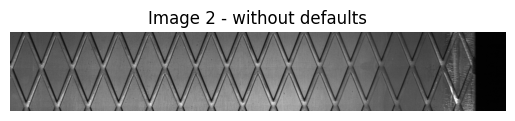

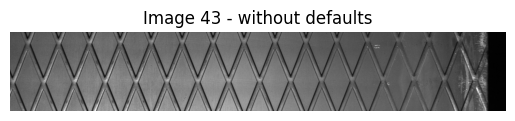

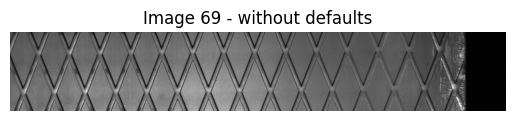

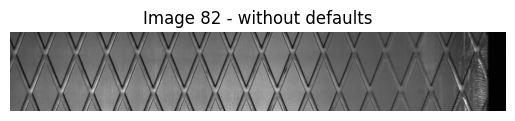

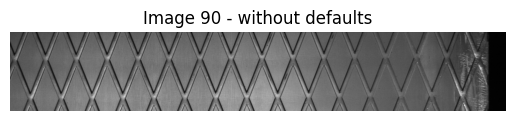

In [8]:
getImage(2)
getImage(43)
getImage(69)
getImage(82)
getImage(90)

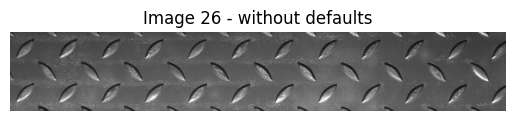

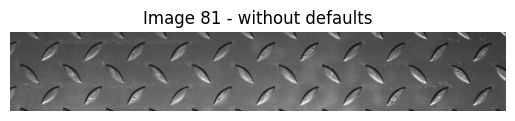

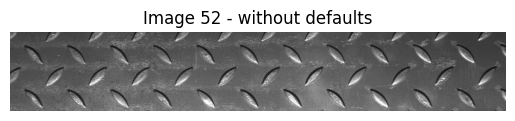

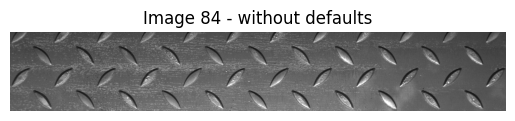

In [9]:
getImage(26)
getImage(81)
getImage(52)
getImage(84)

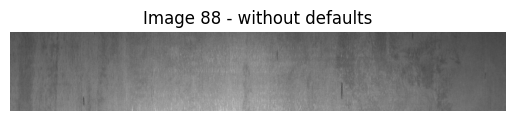

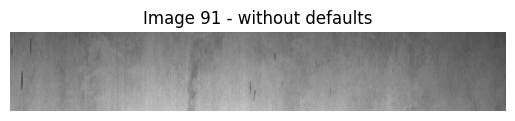

In [10]:
getImage(88)
getImage(91)

# Extracting the dataset

In [11]:
current_directory_path = os.getcwd()
classes_name = ["without_default","with_default"]

We want the folder to follow thistemplate
- dataset/train/class1/
- dataset/train/class2/
- dataset/validation/class1/
- dataset/validation/class2/

In [12]:
def extract():
    """
    Extract folder from the 2 zip files
    """
    zip_file_path_1 = 'EXERCISE_1_train_data_with_default.zip'
    zip_file_path_2 = 'EXERCISE_1_train_data_without_default.zip'
    target_directory_path = current_directory_path + '/dataset' 

    # Open the zip file and extract its contents to the target directory
    with zipfile.ZipFile(zip_file_path_1, 'r') as zip_ref:
        zip_ref.extractall(target_directory_path)
    with zipfile.ZipFile(zip_file_path_2, 'r') as zip_ref:
        zip_ref.extractall(target_directory_path)
    print(f"Data extracted from zip files")

    pass


In [13]:
def rename(new_name_1,new_name_2):
    """
    Rename the folders with class names
    """
    old_name = current_directory_path + "/train_data_without_default"
    new_name = current_directory_path +  "/" + new_name_1
    old_name2 = current_directory_path + "/train_data_with_default"
    new_name2 = current_directory_path +  "/" + new_name_2
    os.rename(old_name, new_name)
    os.rename(old_name2, new_name2)
    print(f"Classes renamed")
    pass

### Imbalance and similitude between the images

To deal with these issues we're going to choose only a small chunk of the dataset for this class. The best thing to do would be to choose the images that have little similitude with other images but this would take a lot of time, instead we're going to choose images randomly.

The images not selected wil be kept in folder named "Extra", we will keep 850 images from the metals without defaults and 5 with defaults

In [14]:
def limitedDataSplit(num_limit=150,data_dir= current_directory_path,random_seed=0,classes=classes_name):
    """
    Choose random images from both classes for the train and validation with stratification 
    """
    for class_name in classes :
        train_path = data_dir + "\\train"
        valid_path = data_dir + "\\validation"
        class_path = os.path.join(data_dir,class_name)
        train_class_path = os.path.join(train_path, class_name)
        valid_class_path = os.path.join(valid_path, class_name)

        os.makedirs(train_class_path)
        os.makedirs(valid_class_path)

        images = os.listdir(class_path)
        if class_name == "with_default":
            num_limit = 95
        random.seed(random_seed)
        random.shuffle(images)
        
        images = images[:num_limit]

        split_idx = int(len(images) * 0.7)
        train_images = images[:split_idx]
        valid_images = images[split_idx:]

        for image in train_images:
            src_path = os.path.join(class_path, image)
            dst_path = os.path.join(train_class_path, image)
            os.rename(src_path, dst_path)

        for image in valid_images:
            src_path = os.path.join(class_path, image)
            dst_path = os.path.join(valid_class_path, image)
            os.rename(src_path, dst_path)
            
    print(f"Data splited")
    pass



In [16]:
# extract the folders
extract()
current_directory_path = current_directory_path + '/dataset' 
# rename foldes
rename(classes_name[0],classes_name[1])


Data extracted from zip files
Classes renamed


# Preprocessing

### Creating the split folders

5 images with defaults, and 850 without are left out randomly

In [ ]:
# split data using a limited number of images for class without_default
limitedDataSplit(150,data_dir=current_directory_path)


In [19]:
def showNumberImages(name_split='train'):
    data_dir = pathlib.Path(current_directory_path)
    with_default_path = os.path.join(data_dir, name_split, classes_name[0])
    without_default_path = os.path.join(data_dir,name_split, classes_name[1])
    image_count_with_default = len(list(Path(with_default_path).glob('*')))
    image_count_without_default = len(list(Path(without_default_path).glob('*')))
    print(f"There are {image_count_with_default} images with default and {image_count_without_default} without ")
    pass

showNumberImages()
showNumberImages('validation')

There are 105 images with default and 66 without 
There are 45 images with default and 29 without 


In [ ]:
def moveExtra():
    """
    Move the images that were not selected for our model
    """
    source_dir1 = current_directory_path + "/" + classes_name[0]
    source_dir2 = current_directory_path + "/" + classes_name[1]
    dest_dir1 = r"C:\Users\Administrateur\Desktop\DevLocal\Datakeen\Extra\without_default" 
    dest_dir2 = r"C:\Users\Administrateur\Desktop\DevLocal\Datakeen\Datakeen\Extra\with_default" 

    # Move the folders
    shutil.move(source_dir1, dest_dir1)
    shutil.move(source_dir2, dest_dir2)
    print('Extra images moved')
    pass    

moveExtra()

### Splitting and data preparation

In [21]:
BATCH_SIZE = 3
IMG_SIZE = (52, 320)
# 1600x256
train_dir = current_directory_path + "/train"
validation_dir = current_directory_path + "/validation"

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             label_mode='binary',
                                             subset='training',
                                             #color_mode='grayscale',
                                             seed=0)
validation_dataset = image_dataset_from_directory(validation_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,

                                             validation_split=0.3,
                                             label_mode='binary',
                                             subset='validation',
                                             #color_mode='grayscale',
                                             seed=0)

Found 171 files belonging to 2 classes.
Using 137 files for training.
Found 74 files belonging to 2 classes.
Using 22 files for validation.


# Modeling

In total we have 250 images which isn't a lot, it might be difficult to get result with such litle dataset that's why we're going to use transfer learning.
The first model to be tested wil be **Mobilnet**, train on imagenet.

In [37]:
# Mobilenet requires the 3 channels
IMG_SHAPE = IMG_SIZE + (3,)

In [38]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential([])
    data_augmentation.add(RandomFlip("horizontal_and_vertical"))
    data_augmentation.add(RandomRotation(0.4))
    return data_augmentation

## Custom Cnn

In [66]:

from tensorflow import keras
from tensorflow.keras import layers

def model_1(image_shape=IMG_SHAPE, data_augmentation=data_augmenter()):
    input_shape = image_shape
    inputs = keras.Input(shape=input_shape)
    x = layers.experimental.preprocessing.Rescaling(scale=1./255)(inputs)
    x = data_augmenter()(x)
    x = layers.Conv2D(128, 4, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 4, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(32, 4, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(16, 4, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['binary_accuracy'])
    return model



In [63]:
"""
from tensorflow.keras import layers

def model_1(image_shape=IMG_SHAPE, data_augmentation=data_augmenter()):
    input_shape = image_shape
    inputs = keras.Input(shape=input_shape)
    x = layers.experimental.preprocessing.Rescaling(scale=1./255)(inputs)
    x = data_augmenter()(x)

    x = layers.Conv2D(128, 4, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(96, 4, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
   
    x = layers.Conv2D(64, 4, activation='relu',padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(32, 4, activation='relu',padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(16, 4, activation='relu',padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['binary_accuracy'])
    return model
    """

In [67]:
model_1 = model_1()
model_1.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 52, 320, 3)]      0         
                                                                 
 rescaling_11 (Rescaling)    (None, 52, 320, 3)        0         
                                                                 
 sequential_23 (Sequential)  (None, 52, 320, 3)        0         
                                                                 
 conv2d_57 (Conv2D)          (None, 52, 320, 128)      6272      
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 26, 160, 128)     0         
 g2D)                                                            
                                                                 
 conv2d_58 (Conv2D)          (None, 26, 160, 64)       131136    
                                                           

## Transfert learning

In [43]:
def model_MNV2(image_shape=IMG_SHAPE, data_augmentation=data_augmenter()):

    input_shape = image_shape
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,include_top=False, weights='imagenet') 
    base_model.trainable = False 

    inputs = tf.keras.Input(shape=input_shape) 
    x = tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255)(inputs)
    x = data_augmenter()(x)
    
    x = base_model(x, training=False) 
    x = tkl.GlobalAveragePooling2D()(x) 
    x = tkl.Dropout(0.2)(x)
    outputs = tkl.Dense(1,activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['binary_accuracy'])
    return model

In [44]:
model_2 = model_MNV2()
model_2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 52, 320, 3)]      0         
                                                                 
 rescaling_5 (Rescaling)     (None, 52, 320, 3)        0         
                                                                 
 sequential_11 (Sequential)  (None, 52, 320, 3)        0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 2, 10, 1280)      2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0   

In [45]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.005,
    restore_best_weights=True,
)

In [68]:
history_1 = model_1.fit(train_dataset, validation_data=validation_dataset, epochs=30,callbacks=[early_stopping])

Epoch 1/30
46/46 [==============================] - 68s 1s/step - loss: 0.7200 - binary_accuracy: 0.5036 - val_loss: 0.6893 - val_binary_accuracy: 0.6818
Epoch 2/30
46/46 [==============================] - 61s 1s/step - loss: 0.6845 - binary_accuracy: 0.6058 - val_loss: 0.6860 - val_binary_accuracy: 0.5455
Epoch 3/30
46/46 [==============================] - 60s 1s/step - loss: 0.6832 - binary_accuracy: 0.5839 - val_loss: 0.6900 - val_binary_accuracy: 0.5455
Epoch 4/30
46/46 [==============================] - 60s 1s/step - loss: 0.6807 - binary_accuracy: 0.5620 - val_loss: 0.6914 - val_binary_accuracy: 0.4091
Epoch 5/30
46/46 [==============================] - 67s 1s/step - loss: 0.6727 - binary_accuracy: 0.6131 - val_loss: 0.6802 - val_binary_accuracy: 0.5455
Epoch 6/30
46/46 [==============================] - 62s 1s/step - loss: 0.6699 - binary_accuracy: 0.6058 - val_loss: 0.6687 - val_binary_accuracy: 0.6818
Epoch 7/30
46/46 [==============================] - 60s 1s/step - loss: 0.65

In [47]:
history_2 = model_2.fit(train_dataset, validation_data=validation_dataset, epochs=30,callbacks=[early_stopping])

Epoch 1/30
46/46 [==============================] - 20s 221ms/step - loss: 0.5635 - binary_accuracy: 0.6934 - val_loss: 0.4070 - val_binary_accuracy: 0.8636
Epoch 2/30
46/46 [==============================] - 6s 119ms/step - loss: 0.3101 - binary_accuracy: 0.8978 - val_loss: 0.2960 - val_binary_accuracy: 0.8636
Epoch 3/30
46/46 [==============================] - 5s 114ms/step - loss: 0.1661 - binary_accuracy: 0.9781 - val_loss: 0.2497 - val_binary_accuracy: 0.8636
Epoch 4/30
46/46 [==============================] - 7s 151ms/step - loss: 0.1421 - binary_accuracy: 0.9781 - val_loss: 0.2323 - val_binary_accuracy: 0.8636
Epoch 5/30
46/46 [==============================] - 6s 120ms/step - loss: 0.1190 - binary_accuracy: 0.9708 - val_loss: 0.2123 - val_binary_accuracy: 0.8636
Epoch 6/30
46/46 [==============================] - 5s 116ms/step - loss: 0.1217 - binary_accuracy: 0.9635 - val_loss: 0.1967 - val_binary_accuracy: 0.8636
Epoch 7/30
46/46 [==============================] - 8s 170ms/st

# Results

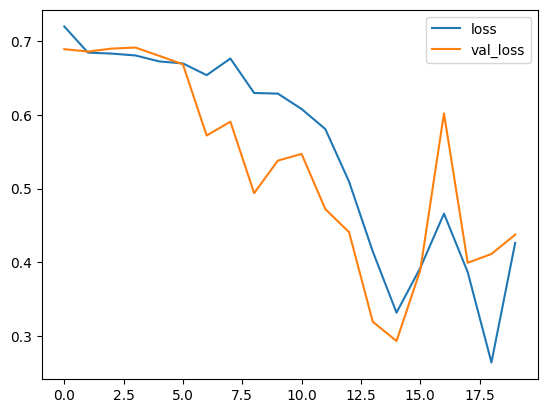

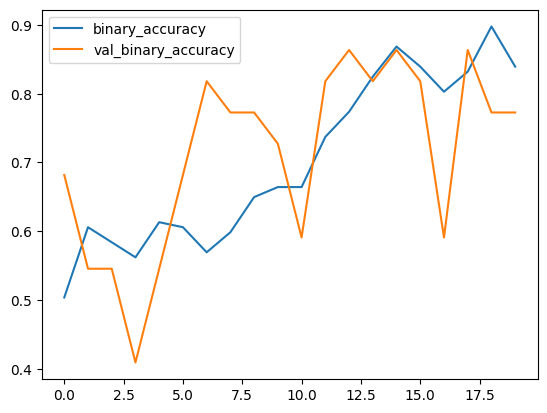

In [69]:
history_frame = pd.DataFrame(history_1.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

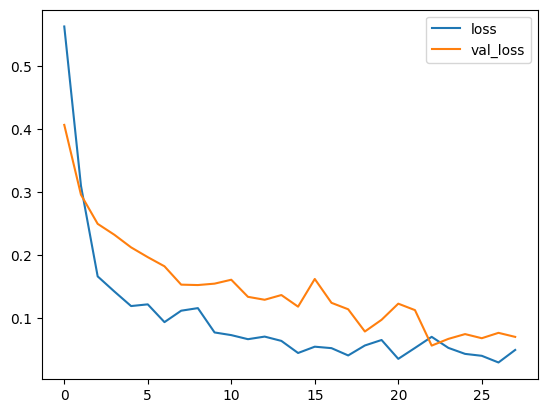

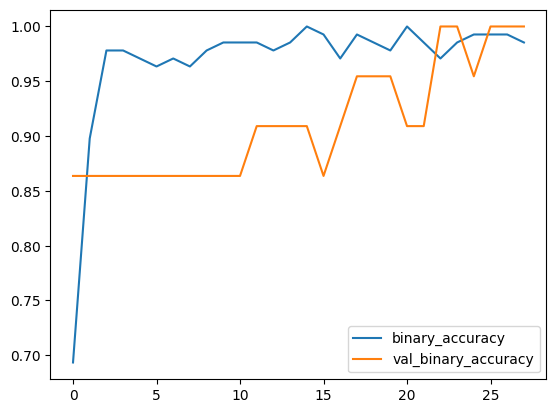

In [49]:
history_frame = pd.DataFrame(history_2.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

## Interpretation